In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ==========================================
# ⚙️ CONFIGURATION (ปรับจูนตรงนี้)
# ==========================================

# Path ของไฟล์ (แก้ให้ตรงกับเครื่องที่คุณรัน Notebook)
# ถ้า Run บนเครื่องตัวเอง (Windows) ให้แก้ Path เป็น C:/...
TRAFFY_PATH = "../Data/clean/bankok_traffy_clean.csv" 
CONDO_DIR = "../Data/clean"
OUTPUT_DIR = "../Data/score"

# 🎯 Parameter การคิดคะแนน
RADIUS_KM = 1.5           # รัศมีรอบคอนโดที่จะนำมาคิด (km)
BASE_SCORE = 1.0          # คะแนนเต็มเริ่มต้น

# ⚖️ Weight (น้ำหนักการหักคะแนน)
W_UNFINISHED = 0.05       # งานไม่เสร็จ (หักหนัก)
W_FINISHED_BAD = 0.01     # งานเสร็จแต่ดาวน้อย (<3 ดาว)
W_FINISHED_GOOD = 0.001   # งานเสร็จและดี (หักนิดเดียว เป็นแค่ Noise)

# 💥 Multiplier สำหรับเคสหนักๆ
KEYWORD_MULTIPLIER = 2.0  # ถ้าเจอคำว่า "น้ำท่วม", "ความปลอดภัย" ให้คูณความแรง 2 เท่า

print(f"⚙️ Config Loaded: Radius={RADIUS_KM}km | Penalty Unfinished={W_UNFINISHED}")

⚙️ Config Loaded: Radius=1.5km | Penalty Unfinished=0.05


In [3]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    """
    คำนวณระยะทาง (km) ระหว่างจุด 1 จุด (lat1) กับ หลายจุด (lat2 array)
    """
    R = 6371  # รัศมีโลก (km)
    
    # แปลง Degree -> Radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

In [4]:
def calculate_happiness_vectorized(condo_lat, condo_lon, traffy_df):
    """
    ฟังก์ชันหลักในการคิดคะแนนต่อ 1 คอนโด
    """
    if traffy_df.empty:
        return BASE_SCORE

    # 1. คำนวณระยะทางทั้งหมดรวดเดียว
    dists = haversine_vectorized(condo_lat, condo_lon, traffy_df['lat'].values, traffy_df['lon'].values)
    
    # 2. กรองเฉพาะที่อยู่ในรัศมี (Filter Mask)
    mask = dists <= RADIUS_KM
    nearby_issues = traffy_df[mask].copy()
    nearby_dists = dists[mask]
    
    if len(nearby_issues) == 0:
        return BASE_SCORE

    # 3. เตรียม Weight เบื้องต้นตาม State
    # สร้าง array ของ weight ขึ้นมา
    weights = np.where(
        nearby_issues['state'] == 'เสร็จสิ้น',
        np.where(nearby_issues['star'].fillna(0) < 3, W_FINISHED_BAD, W_FINISHED_GOOD),
        W_UNFINISHED
    )
    
    # 4. Keyword Boosting (น้ำท่วม/ความปลอดภัย)
    # เช็คว่ามี keyword ไหม (Vectorized string check)
    keywords_mask = nearby_issues['type'].astype(str).str.contains('น้ำท่วม|ความปลอดภัย', na=False)
    weights[keywords_mask] *= KEYWORD_MULTIPLIER
    
    # 5. Distance Decay (ยิ่งไกล ยิ่งผลน้อย)
    # ที่ระยะ 0km -> factor = 1.0
    # ที่ระยะ RADIUS_KM -> factor = 0.0
    dist_factors = 1.0 - (nearby_dists / RADIUS_KM)
    
    # 6. รวม Penalty
    # Penalty = sum(weight * dist_factor)
    total_penalty = np.sum(weights * dist_factors)
    
    # 7. Final Score (Clip ไม่ให้ต่ำกว่า 0)
    # final_score = max(0.0, BASE_SCORE - total_penalty)
    final_score = BASE_SCORE - total_penalty
    
    return final_score

In [5]:
# Load Traffy Data
if os.path.exists(TRAFFY_PATH):
    df_traffy_all = pd.read_csv(TRAFFY_PATH)
    
    # Clean Coordinates
    df_traffy_all = df_traffy_all.dropna(subset=['lat', 'lon'])
    df_traffy_all['lat'] = pd.to_numeric(df_traffy_all['lat'], errors='coerce')
    df_traffy_all['lon'] = pd.to_numeric(df_traffy_all['lon'], errors='coerce')
    
    print(f"✅ Loaded Traffy Data: {len(df_traffy_all):,} rows")
    display(df_traffy_all.head(3))
else:
    print(f"❌ File not found: {TRAFFY_PATH}")

✅ Loaded Traffy Data: 180,403 rows


,ticket_id,type,organization,comment,photo,photo_after,coords,address,subdistrict,district,province,timestamp,state,star,count_reopen,last_activity,lon,lat,cluster
0,2022-8QL8RE,{ถนน},"เขตจตุจักร,สน.พหลโยธิน,สำนักงานตำรวจแห่งชาติ (...",ถนน,https://storage.googleapis.com/traffy_public_b...,NaN,"100.56270,13.81236",93 ถ. ลาดพร้าว แขวง จอมพล เขตจตุจักร กรุงเทพมห...,จอมพล,จตุจักร,กรุงเทพมหานคร,2022-04-10 16:14:18.780788+00,กำลังดำเนินการ,NaN,0,2024-03-05 23:39:54.014906+00,100.56270,13.81236,0
1,2022-9GW7CE,{ถนน},"เขตจตุจักร,สำนักการโยธา กทม.,กองควบคุมการก่อสร...",ฝนตกถนนลื่นขี้เลนตรวจสอบ หน่วยงานไหนเป็นผู้รับ...,https://storage.googleapis.com/traffy_public_b...,https://storage.googleapis.com/traffy_public_b...,"100.58576,13.85828",2673 ถ. พหลโยธิน แขวง ลาดยาว เขตจตุจักร กรุงเท...,ลาดยาว,จตุจักร,กรุงเทพมหานคร,2022-04-30 04:57:49.906226+00,เสร็จสิ้น,3.0,0,2024-05-20 13:05:34.528824+00,100.58576,13.85828,0
2,2022-UK897G,"{ทางเท้า,ถนน}",โครงการรถไฟฟ้าสายสีเขียวเหนือ (ถนนพหลโยธิน และ...,ทางเท้าสภาพแตกร้าว ถ้าเป็นผู้พอการไม่น่าจะผ่าน...,https://storage.googleapis.com/traffy_public_b...,https://storage.googleapis.com/traffy_public_b...,"100.56301,13.81809",1194/9 ถ. พหลโยธิน แขวง จอมพล เขตจตุจักร กรุงเ...,จตุจักร,จตุจักร,กรุงเทพมหานคร,2022-05-02 10:24:20.109196+00,กำลังดำเนินการ,NaN,1,2024-11-04 04:09:50.716992+00,100.56301,13.81809,0


In [6]:
# ==========================================
# 📐 NORMALIZATION SETTINGS
# ==========================================
# ปรับตามข้อมูลจริงที่คุณเจอ (-109.31 และ -3.93)
MIN_RAW = -115.0  # ขอบล่าง (แย่สุด -> Score 0.0) เผื่อไว้ต่ำกว่า -109 นิดหน่อย
MAX_RAW = -3.0    # ขอบบน (ดีสุด -> Score 1.0)

print(f"📏 Scale Range: {MIN_RAW} (Bad) to {MAX_RAW} (Good)")

# หาไฟล์
condo_files = glob.glob(os.path.join(CONDO_DIR, "condo_*_clean.csv"))
os.makedirs(OUTPUT_DIR, exist_ok=True)
all_scored_data = []

print(f"🚀 Start Scoring for {len(condo_files)} districts...\n")

for file_path in condo_files:
    district_name = os.path.basename(file_path).replace("condo_", "").replace("_clean.csv", "")
    print(f"📍 Processing: {district_name}")
    
    # 1. Load Condo Data
    df_condo = pd.read_csv(file_path)
    
    # 2. Filter Traffy
    df_traffy_local = df_traffy_all[df_traffy_all['district'].astype(str).str.contains(district_name, na=False)]
    
    if df_traffy_local.empty:
        # ไม่มีข้อมูล Traffy เลย -> Raw = 0 -> Normalized = 1.0
        df_condo['raw_score'] = 0.0
        df_condo['happiness_score'] = 1.0
        df_condo['issue_count'] = 0
    else:
        # 3. คำนวณ Raw Score (ค่าติดลบ)
        # เรียกใช้ฟังก์ชันใหม่ calculate_raw_negative_score
        raw_scores = df_condo.apply(
            lambda row: calculate_happiness_vectorized(row['latitude'], row['longitude'], df_traffy_local), 
            axis=1
        )
        df_condo['raw_score'] = raw_scores
        
        # 4. Normalize Logic
        # สูตร: (Score - Min) / (Max - Min)
        # แทนค่า: (raw - (-115)) / (-3 - (-115))
        denominator = MAX_RAW - MIN_RAW  # ช่วงกว้างของคะแนน
        normalized = (raw_scores - MIN_RAW) / denominator
        
        # 5. Clip ค่าให้อยู่ในช่วง 0.0 - 1.0 (ห้ามเกิน)
        # - ถ้า raw < -115 จะได้ 0.0
        # - ถ้า raw > -3 จะได้ 1.0
        df_condo['happiness_score'] = normalized.clip(0.0, 1.0).round(4)
        
    # 5. Save & Collect
    output_path = os.path.join(OUTPUT_DIR, f"condo_{district_name}_scored.csv")
    df_condo.to_csv(output_path, index=False, encoding='utf-8-sig')
    
    all_scored_data.append(df_condo)

print("\n✅ All Done! Files saved to:", OUTPUT_DIR)

df_final = pd.concat(all_scored_data, ignore_index=True)
final_output_path = os.path.join(OUTPUT_DIR, "condo_score_all.csv")
df_final.to_csv(final_output_path, index=False, encoding="utf-8-sig")

# --- ตรวจสอบผลลัพธ์ ---
if all_scored_data:
    df_check = pd.concat(all_scored_data)
    print("\n🔍 Check Normalization Result:")
    print("Top 3 Happiest:")
    display(df_check[['condo_name', 'raw_score', 'happiness_score']].sort_values(by='happiness_score', ascending=False).head(3))
    print("Top 3 Saddest:")
    display(df_check[['condo_name', 'raw_score', 'happiness_score']].sort_values(by='happiness_score', ascending=True).head(3))

📏 Scale Range: -115.0 (Bad) to -3.0 (Good)
🚀 Start Scoring for 8 districts...

📍 Processing: คลองเตย
📍 Processing: จตุจักร
📍 Processing: บางกะปิ
📍 Processing: บางเขน
📍 Processing: บางแค
📍 Processing: ปทุมวัน
📍 Processing: ประเวศ
📍 Processing: วัฒนา

✅ All Done! Files saved to: ../Data/score

🔍 Check Normalization Result:
Top 3 Happiest:


,condo_name,raw_score,happiness_score
151,Notting Hill Phahol - Kaset,-3.934198,0.9917
107,Notting Hill Phahol - Kaset,-3.934198,0.9917
105,Notting Hill Phahol - Kaset,-3.934198,0.9917


Top 3 Saddest:


,condo_name,raw_score,happiness_score
111,Magnolias Ratchadamri Boulevard,-109.314115,0.0508
21,Magnolias Ratchadamri Boulevard,-109.314115,0.0508
5,Magnolias Ratchadamri Boulevard,-109.314115,0.0508


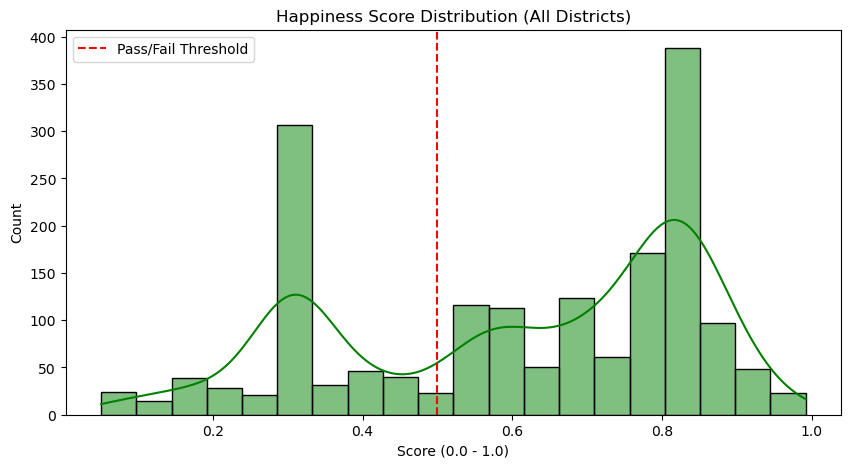

🏆 Top 5 Happiest Condos:


,condo_name,district_name,happiness_score
840,Notting Hill Phahol - Kaset,เขตบางเขน,0.9917
796,Notting Hill Phahol - Kaset,เขตบางเขน,0.9917
794,Notting Hill Phahol - Kaset,เขตบางเขน,0.9917
768,Notting Hill Phahol - Kaset,เขตบางเขน,0.9917
841,Notting Hill Phahol - Kaset,เขตบางเขน,0.9917


💀 Top 5 Saddest Condos:


,condo_name,district_name,happiness_score
1203,Magnolias Ratchadamri Boulevard,เขตปทุมวัน,0.0508
1113,Magnolias Ratchadamri Boulevard,เขตปทุมวัน,0.0508
1097,Magnolias Ratchadamri Boulevard,เขตปทุมวัน,0.0508
1121,Magnolias Ratchadamri Boulevard,เขตปทุมวัน,0.0508
1098,Magnolias Ratchadamri Boulevard,เขตปทุมวัน,0.0508


In [7]:
# รวมข้อมูลทุกเขตมาดูภาพรวม
if all_scored_data:
    df_final = pd.concat(all_scored_data, ignore_index=True)

    # 1. ดู Distribution ของคะแนน
    plt.figure(figsize=(10, 5))
    sns.histplot(df_final['happiness_score'], bins=20, kde=True, color='green')
    plt.title('Happiness Score Distribution (All Districts)')
    plt.xlabel('Score (0.0 - 1.0)')
    plt.axvline(x=0.5, color='red', linestyle='--', label='Pass/Fail Threshold')
    plt.legend()
    plt.show()

    # 2. ดู Top 5 Condo ที่มีความสุขที่สุด
    print("🏆 Top 5 Happiest Condos:")
    display(df_final[['condo_name', 'district_name', 'happiness_score']].sort_values(by='happiness_score', ascending=False).head(5))

    # 3. ดู Bottom 5 Condo ที่น่าสงสารที่สุด
    print("💀 Top 5 Saddest Condos:")
    display(df_final[['condo_name', 'district_name', 'happiness_score']].sort_values(by='happiness_score', ascending=True).head(5))

In [8]:
all_scored_data

[                                          Project_Name  \
 0    คอนโด 3-ห้องนอน ที่ ไซมิส เอ๊กซ์คลูซีพ 42 ใกล้...   
 1    คอนโด 3-ห้องนอน ที่ มะฮอกกานี ทาวเวอร์ คอนโดมิ...   
 2    ขาย ไลฟ์ สุขุมวิท 48 ราคาถูก ต้องขาย ! ตกแต่งส...   
 3    คอนโด 1-ห้องนอน ที่ เดอะ ลุมพินี 24 ใกล้ BTS พ...   
 4    คอนโด 2-ห้องนอน ที่ บ้าน สุขุมวิท ใกล้ BTS ทอง...   
 ..                                                 ...   
 160  คอนโด 2-ห้องนอน ที่ ไลฟ์ พระราม 4 - อโศก ใกล้ ...   
 161  คอนโด 1-ห้องนอน ที่ ไอดีโอ คิว สุขุมวิท 36 ใกล...   
 162  คอนโด 2-ห้องนอน ที่ ดิ เอส สุขุมวิท 36 ใกล้ BT...   
 163  คอนโด 1-ห้องนอน ที่ ดิ เอสเทลล์ พร้อมพงษ์ ใกล้...   
 164  คอนโด 2-ห้องนอน ที่ พาร์ค ออริจิ้น พร้อมพงษ์ ใ...   
 
                          condo_name     Price  Room_Type Floor   Bedrooms  \
 0    Siamese Exclusive Sukhumvit 42  15000000  3 ห้องนอน    23  3 ห้องนอน   
 1                    Mahogany Tower  44000000  3 ห้องนอน    21  3 ห้องนอน   
 2                 Life Sukhumvit 48   4880000  2 ห้องนอ